In [1]:
year=2019
month=11

In [2]:
import pandas as pd
import sys
sys.path.append('../../py')
import db
import weighted
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math


In [3]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [4]:
conn=db.get_conn()

In [5]:

cities = """
('北京','上海','深圳','杭州','广州','南京','苏州','成都','东莞','西安','武汉','天津','长沙',
'宁波','福州','大连','重庆','青岛','济南','合肥','长春','昆明','郑州','沈阳','哈尔滨','厦门')
"""
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and monthly_salary<80000 and city in {cities}", con=conn)


In [6]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [7]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

In [8]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['平均工资']=salary_mean
    sub_data['最低工资']=salary_95_min
    sub_data['中位数']=salary_median
    sub_data['最高工资']=salary_95_max
    sub_data['招聘人数']=count
    sub_data['百分比']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='平均工资', ascending=False)

    return sub_data

data_format={"百分比":"{:.2%}","平均工资":"{:.0f}","中位数":"{:.0f}","最低工资":"{:.0f}","最高工资":"{:.0f}"}

translate_dict={}

def describe(data_city, career):
    
    for index, row in data_city.iterrows():
        print(f"{year}年{month}月{row[0]}招收{career}{row[5]}人。{year}年{month}月{row[0]}{career}平均工资{row[1]:.0f}元，工资中位数{row[3]:.0f}元，其中95%的人的工资介于{row[2]:.0f}元到{row[4]:.0f}元。\r\n")

        
from mpl_toolkits.basemap import Basemap

def draw_map(data_city,headcount_scale, title):


    #cities = []
    scale = 5

    locations = [(116.407526, 39.90403),(120, 30)]
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = [13, 13]
    #plt.figure(figsize = (10,5))
    fig, ax = plt.subplots()
    fig.title=title
    fig.figsize=(10,5)
    fig.dpi=80
    cn_map= Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
               projection='lcc', lat_1=33, lat_2=45, lon_0=100) # ‘lcc'将投影方式设置为兰伯特投影

    # load the shapefile, use the name 'states'
    cn_map.readshapefile(r'D:/data/basemap/gadm36_CHN_shp/gadm36_CHN_1', name='china', drawbounds=True, color='gray')
    cn_map.readshapefile(r'D:/data/basemap/gadm36_TWN_shp/gadm36_TWN_1', name='taiwan', drawbounds=True, color='gray')
    #geolocator = Nominatim(user_agent="my-application")



    salary_min=data_city['平均工资'].min()
    salary_max=data_city['平均工资'].max()
    salary_middle = (salary_min+salary_max)/2
    salary_scale=salary_max-salary_min

    for index, row in data_city.iterrows():
        city=row[0]
        
        longitude = data_location.loc[city,'longitude']
        latitude = data_location.loc[city,'latitude']
        salary=row[1]
        headcount=row[5]
        #color
        color_red=0
        color_green=0
        color_blue=0
        if salary>salary_middle:
            color_red = 255 #int((salary - salary_middle) / (salary_scale/2)*255)
            color_green = int((salary_max - salary) / (salary_scale/2)*255)
        else:
            color_blue = int((salary_middle - salary) / (salary_scale/2)*255)
            color_green = int((salary - salary_min) / (salary_scale/2)*255)
            color_red = int((salary - salary_min) / (salary_scale/2)*255)

        color = '#{:02x}{:02x}{:02x}'.format(color_red,color_green,color_blue)


        x, y = cn_map(longitude,latitude)
        cn_map.plot(x,y,marker='o',color=color,markersize=int(math.sqrt(headcount/headcount_scale))+8)
        #ax.annotate(city, (x,y), xytext=(5, 5), textcoords='offset points', fontsize=15)
        #"{}{:.0f}".format(city_cn, salary)
        #ax.text(x+5, y+5,city , fontweight='bold', fontsize=int(headcount/2500+12))
        fontsize=int(math.sqrt(headcount/headcount_scale))+13
        if city == '杭州':
            x=x-400000
            y=y+10000
        elif city=='广州':
            x=x-400000
            y=y+10000
        elif city=='合肥':
            x=x-300000
            y=y+10000
        elif city=='深圳':
            y=y-100000
        elif city=='南京':
            x=x-100000
        elif city=='天津':
            y=y-50000
        elif city=='上海':
            x=x+50000
        elif city=='武汉':
            y=y-50000
        elif city=='厦门':
            pass
        elif city=='福州':
            pass
        elif city=='苏州':
            y=y-100000
            pass
        elif city=='宁波':
            y=y-100000
            pass

        ax.text(x, y, "{}{:.0f}k".format(city, np.round(salary/1000)), fontweight='bold', fontsize=fontsize, bbox={'facecolor':color, 'alpha':0.3, 'pad':0})
    ax.text(1100000, 1077845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(205805, 107845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(805805, 4007845, title.format(city, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=25)    
    ax.text(805805, 3807845, "（城市大小代表招聘数量，颜色代表工资，红色最高，黄色次之，蓝最少）", fontweight='bold',color='#111111', fontsize=13)    
    #cn_map.drawcoastlines() #绘制海岸线
    #cn_map.drawcountries(linewidth=1.5) #绘制国家边界线
    plt.show()
      
    
data_location = pd.read_csv('../city_locations.csv')
data_location=data_location.set_index('city')

# 程序员工资

In [9]:
data_city=get_sub_stats_by_col(data,'city')
data_city.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
1,北京,17714,3750,15000,45000,24282,9.67%
2,上海,16390,5250,15000,37500,43913,17.49%
8,深圳,16208,5250,14583,37500,36389,14.49%
3,杭州,14922,3750,12500,35000,13053,5.20%
4,广州,13618,3750,12500,30000,27943,11.13%
9,南京,13180,4500,12500,28750,13670,5.44%
6,成都,12221,3547,11500,29818,11455,4.56%
14,东莞,12136,4000,12500,24000,2849,1.13%
11,苏州,11957,3750,11500,25667,7000,2.79%
7,大连,11773,3000,9500,31266,9081,3.62%


In [11]:
describe(data_city,'程序员')

2019年11月北京招收程序员24282人。2019年11月北京程序员平均工资17714元，工资中位数15000元，其中95%的人的工资介于3750元到45000元。

2019年11月上海招收程序员43913人。2019年11月上海程序员平均工资16390元，工资中位数15000元，其中95%的人的工资介于5250元到37500元。

2019年11月深圳招收程序员36389人。2019年11月深圳程序员平均工资16208元，工资中位数14583元，其中95%的人的工资介于5250元到37500元。

2019年11月杭州招收程序员13053人。2019年11月杭州程序员平均工资14922元，工资中位数12500元，其中95%的人的工资介于3750元到35000元。

2019年11月广州招收程序员27943人。2019年11月广州程序员平均工资13618元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年11月南京招收程序员13670人。2019年11月南京程序员平均工资13180元，工资中位数12500元，其中95%的人的工资介于4500元到28750元。

2019年11月成都招收程序员11455人。2019年11月成都程序员平均工资12221元，工资中位数11500元，其中95%的人的工资介于3547元到29818元。

2019年11月东莞招收程序员2849人。2019年11月东莞程序员平均工资12136元，工资中位数12500元，其中95%的人的工资介于4000元到24000元。

2019年11月苏州招收程序员7000人。2019年11月苏州程序员平均工资11957元，工资中位数11500元，其中95%的人的工资介于3750元到25667元。

2019年11月大连招收程序员9081人。2019年11月大连程序员平均工资11773元，工资中位数9500元，其中95%的人的工资介于3000元到31266元。

2019年11月武汉招收程序员14580人。2019年11月武汉程序员平均工资11675元，工资中位数11000元，其中95%的人的工资介于3750元到25000元。

2019年11月长沙招收程序员5713人。2019年11月长沙程序员平均工资11202元，工资中位数10500元，其中95%的人的工资介于

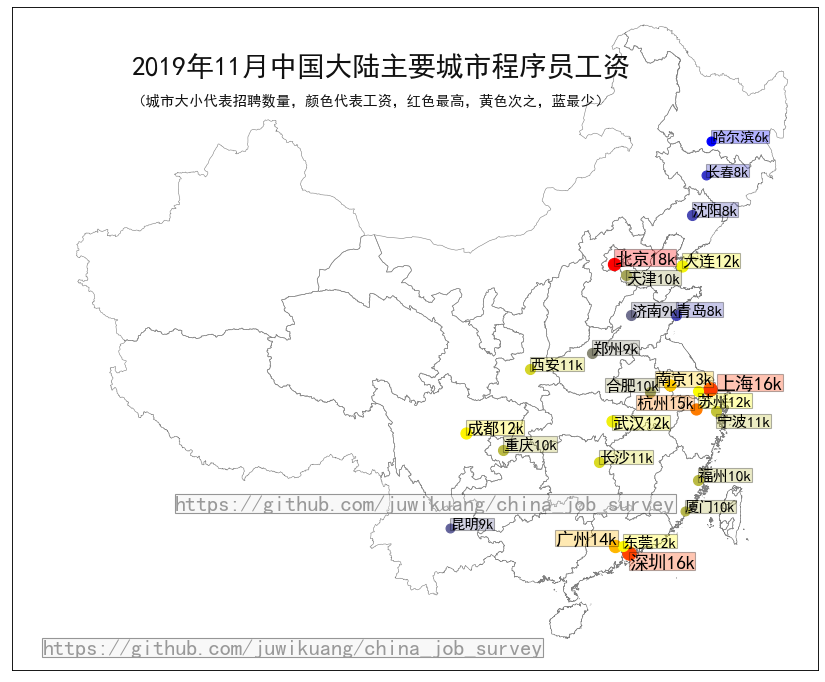

In [15]:
draw_map(data_city,2000,f'{year}年{month}月中国大陆主要城市程序员工资')

# 区块链工程师

In [16]:
data_blockchain=get_sub_stats_by_col(data[(data.expert_blockchain==1)],'city')

data_blockchain.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
14,厦门,32500,32500,32500,32500,1,0.19%
1,上海,27260,11500,23000,71875,75,14.07%
3,西安,22500,22500,22500,22500,1,0.19%
4,深圳,21939,2500,22500,40000,76,14.26%
6,北京,19905,4341,17500,40000,58,10.88%
10,郑州,18643,9000,18643,22500,7,1.31%
2,广州,18271,6000,15000,39083,192,36.02%
9,南京,17308,12500,16250,27500,13,2.44%
5,成都,17288,11500,14923,40604,33,6.19%
7,杭州,17164,2500,18800,29166,37,6.94%


In [17]:
describe(data_blockchain,'区块链工程师')

2019年11月厦门招收区块链工程师1人。2019年11月厦门区块链工程师平均工资32500元，工资中位数32500元，其中95%的人的工资介于32500元到32500元。

2019年11月上海招收区块链工程师75人。2019年11月上海区块链工程师平均工资27260元，工资中位数23000元，其中95%的人的工资介于11500元到71875元。

2019年11月西安招收区块链工程师1人。2019年11月西安区块链工程师平均工资22500元，工资中位数22500元，其中95%的人的工资介于22500元到22500元。

2019年11月深圳招收区块链工程师76人。2019年11月深圳区块链工程师平均工资21939元，工资中位数22500元，其中95%的人的工资介于2500元到40000元。

2019年11月北京招收区块链工程师58人。2019年11月北京区块链工程师平均工资19905元，工资中位数17500元，其中95%的人的工资介于4341元到40000元。

2019年11月郑州招收区块链工程师7人。2019年11月郑州区块链工程师平均工资18643元，工资中位数18643元，其中95%的人的工资介于9000元到22500元。

2019年11月广州招收区块链工程师192人。2019年11月广州区块链工程师平均工资18271元，工资中位数15000元，其中95%的人的工资介于6000元到39083元。

2019年11月南京招收区块链工程师13人。2019年11月南京区块链工程师平均工资17308元，工资中位数16250元，其中95%的人的工资介于12500元到27500元。

2019年11月成都招收区块链工程师33人。2019年11月成都区块链工程师平均工资17288元，工资中位数14923元，其中95%的人的工资介于11500元到40604元。

2019年11月杭州招收区块链工程师37人。2019年11月杭州区块链工程师平均工资17164元，工资中位数18800元，其中95%的人的工资介于2500元到29166元。

2019年11月武汉招收区块链工程师22人。2019年11月武汉区块链工程师平均工资14841元，工资中位数12500元，其中95%的人的工资介于7000元到25000元。

2019年11月济南招收区块链工程师3人。2019年11月

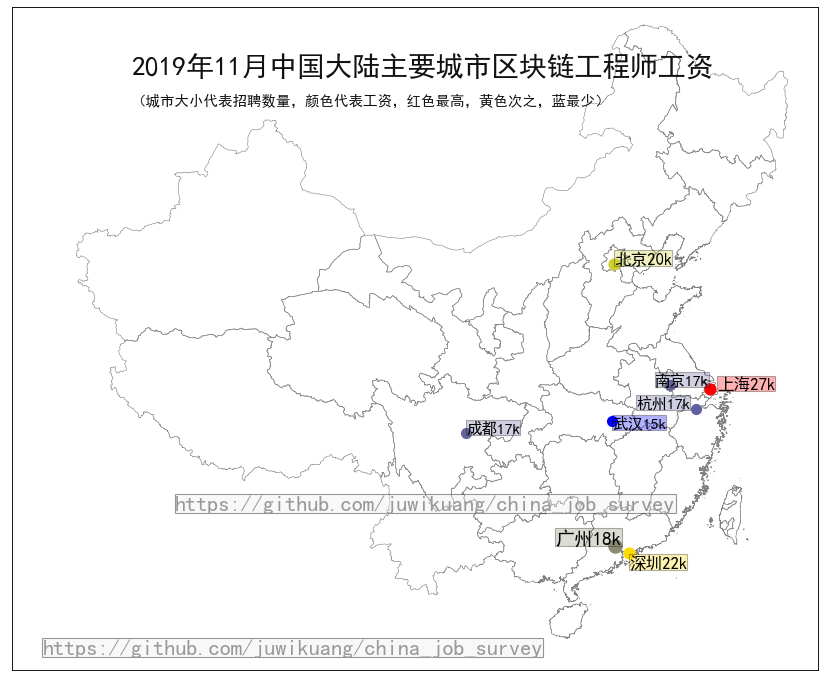

In [18]:
draw_map(data_blockchain[data_blockchain['招聘人数']>10],10,f'{year}年{month}月中国大陆主要城市区块链工程师工资')

# 算法工程师

In [19]:
data_city_algorithm=get_sub_stats_by_col(data[data.career=='算法工程师'],'city')
data_city_algorithm.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
0,北京,23085,5250,20000,58333,3049,13.43%
1,上海,22109,7000,20000,45833,4665,20.55%
5,深圳,20505,5000,17500,45000,3689,16.25%
8,杭州,18898,3750,17500,45000,1498,6.60%
3,广州,17920,4718,17000,37500,2357,10.38%
10,南京,17327,6688,16000,35000,1185,5.22%
15,苏州,16675,4862,15000,35929,907,3.99%
9,成都,15356,5250,14000,35500,996,4.39%
11,武汉,15227,3805,15000,27500,1191,5.25%
12,厦门,14535,6000,13812,27125,86,0.38%


In [20]:
describe(data_city_algorithm,'算法工程师')

2019年11月北京招收算法工程师3049人。2019年11月北京算法工程师平均工资23085元，工资中位数20000元，其中95%的人的工资介于5250元到58333元。

2019年11月上海招收算法工程师4665人。2019年11月上海算法工程师平均工资22109元，工资中位数20000元，其中95%的人的工资介于7000元到45833元。

2019年11月深圳招收算法工程师3689人。2019年11月深圳算法工程师平均工资20505元，工资中位数17500元，其中95%的人的工资介于5000元到45000元。

2019年11月杭州招收算法工程师1498人。2019年11月杭州算法工程师平均工资18898元，工资中位数17500元，其中95%的人的工资介于3750元到45000元。

2019年11月广州招收算法工程师2357人。2019年11月广州算法工程师平均工资17920元，工资中位数17000元，其中95%的人的工资介于4718元到37500元。

2019年11月南京招收算法工程师1185人。2019年11月南京算法工程师平均工资17327元，工资中位数16000元，其中95%的人的工资介于6688元到35000元。

2019年11月苏州招收算法工程师907人。2019年11月苏州算法工程师平均工资16675元，工资中位数15000元，其中95%的人的工资介于4862元到35929元。

2019年11月成都招收算法工程师996人。2019年11月成都算法工程师平均工资15356元，工资中位数14000元，其中95%的人的工资介于5250元到35500元。

2019年11月武汉招收算法工程师1191人。2019年11月武汉算法工程师平均工资15227元，工资中位数15000元，其中95%的人的工资介于3805元到27500元。

2019年11月厦门招收算法工程师86人。2019年11月厦门算法工程师平均工资14535元，工资中位数13812元，其中95%的人的工资介于6000元到27125元。

2019年11月长沙招收算法工程师442人。2019年11月长沙算法工程师平均工资14408元，工资中位数12500元，其中95%的人的工资介于7000元到28625元。

2019年11月合肥招收算法工程师241人。2019年11月合肥算法工程师

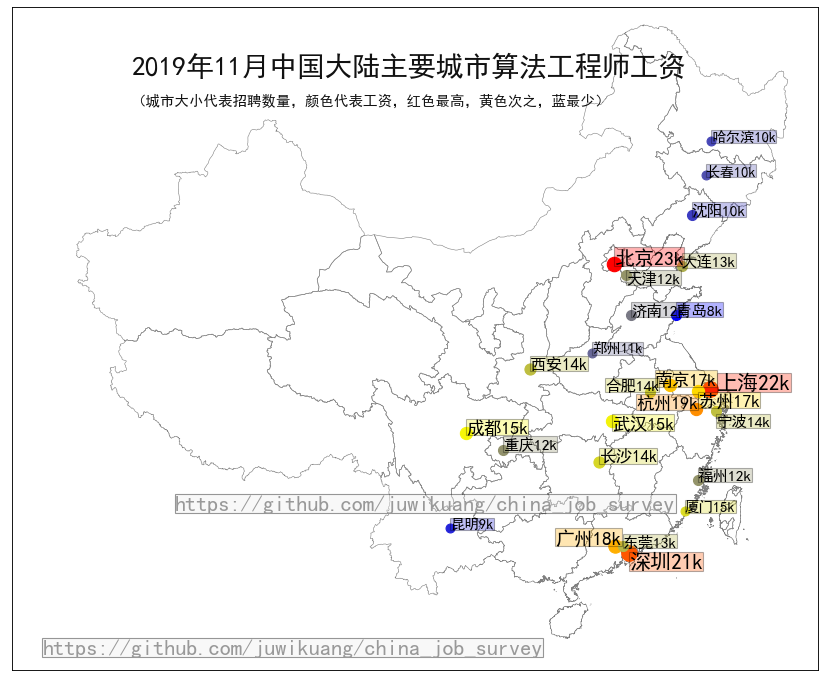

In [21]:
draw_map(data_city_algorithm,100,f'{year}年{month}月中国大陆主要城市算法工程师工资')

# 系统架构师

In [22]:
data_city_architect=get_sub_stats_by_col(data[data.career=='系统架构师'],'city')
data_city_architect.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
6,北京,31840,9000,32500,60000,1116,13.77%
9,深圳,26760,5875,26167,52500,1105,13.64%
3,杭州,25773,9291,25000,45000,438,5.41%
4,上海,22989,7000,22500,50000,1867,23.04%
5,南京,20836,6950,20000,38550,376,4.64%
2,广州,20597,5205,20000,41666,1218,15.03%
10,成都,19547,6940,19500,39000,316,3.90%
19,郑州,18167,6500,18750,30000,12,0.15%
14,东莞,18070,7000,15625,37902,83,1.02%
0,大连,17911,8014,17250,33250,88,1.09%


In [23]:
describe(data_city_architect,'系统架构师')

2019年11月北京招收系统架构师1116人。2019年11月北京系统架构师平均工资31840元，工资中位数32500元，其中95%的人的工资介于9000元到60000元。

2019年11月深圳招收系统架构师1105人。2019年11月深圳系统架构师平均工资26760元，工资中位数26167元，其中95%的人的工资介于5875元到52500元。

2019年11月杭州招收系统架构师438人。2019年11月杭州系统架构师平均工资25773元，工资中位数25000元，其中95%的人的工资介于9291元到45000元。

2019年11月上海招收系统架构师1867人。2019年11月上海系统架构师平均工资22989元，工资中位数22500元，其中95%的人的工资介于7000元到50000元。

2019年11月南京招收系统架构师376人。2019年11月南京系统架构师平均工资20836元，工资中位数20000元，其中95%的人的工资介于6950元到38550元。

2019年11月广州招收系统架构师1218人。2019年11月广州系统架构师平均工资20597元，工资中位数20000元，其中95%的人的工资介于5205元到41666元。

2019年11月成都招收系统架构师316人。2019年11月成都系统架构师平均工资19547元，工资中位数19500元，其中95%的人的工资介于6940元到39000元。

2019年11月郑州招收系统架构师12人。2019年11月郑州系统架构师平均工资18167元，工资中位数18750元，其中95%的人的工资介于6500元到30000元。

2019年11月东莞招收系统架构师83人。2019年11月东莞系统架构师平均工资18070元，工资中位数15625元，其中95%的人的工资介于7000元到37902元。

2019年11月大连招收系统架构师88人。2019年11月大连系统架构师平均工资17911元，工资中位数17250元，其中95%的人的工资介于8014元到33250元。

2019年11月武汉招收系统架构师392人。2019年11月武汉系统架构师平均工资17460元，工资中位数17500元，其中95%的人的工资介于5650元到31000元。

2019年11月西安招收系统架构师198人。2019年11月西安系统架构师平均工资1

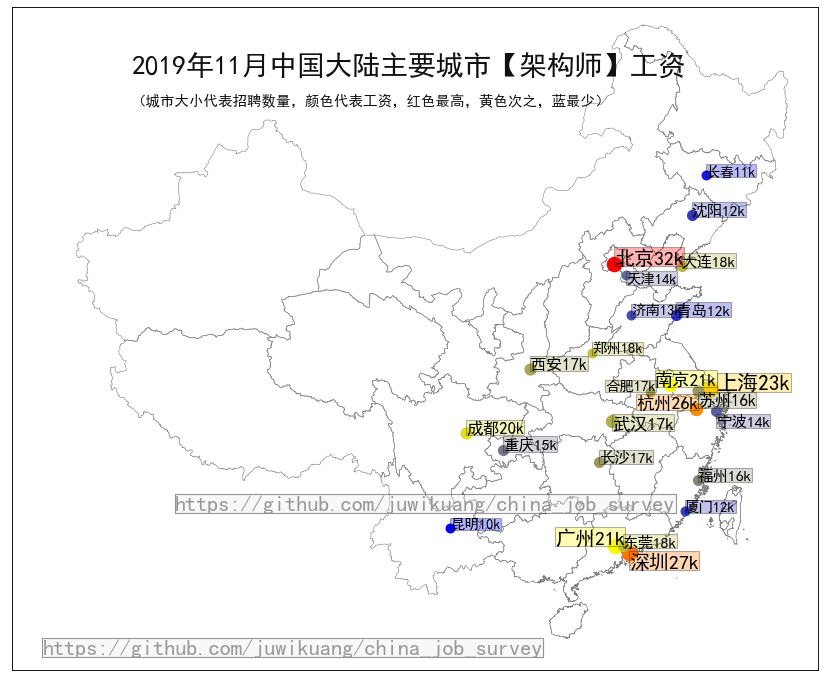

In [24]:
draw_map(data_city_architect,40,f'{year}年{month}月中国大陆主要城市【架构师】工资')

# 生物信息工程师

In [25]:
data_bio=get_sub_stats_by_col(data[data.career=='生物信息工程师'],'city')
data_bio.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
4,北京,15000,15000,15000,15000,5,15.62%
2,苏州,12500,12500,12500,12500,1,3.12%
0,广州,12100,7000,13125,15000,10,31.25%
6,长春,11500,11500,11500,11500,2,6.25%
5,上海,9800,8000,9800,12500,5,15.62%
3,武汉,9000,9000,9000,9000,1,3.12%
7,南京,9000,9000,9000,9000,3,9.38%
1,深圳,7500,7500,7500,7500,5,15.62%


In [26]:
describe(data_bio,'生物信息工程师')

2019年11月北京招收生物信息工程师5人。2019年11月北京生物信息工程师平均工资15000元，工资中位数15000元，其中95%的人的工资介于15000元到15000元。

2019年11月苏州招收生物信息工程师1人。2019年11月苏州生物信息工程师平均工资12500元，工资中位数12500元，其中95%的人的工资介于12500元到12500元。

2019年11月广州招收生物信息工程师10人。2019年11月广州生物信息工程师平均工资12100元，工资中位数13125元，其中95%的人的工资介于7000元到15000元。

2019年11月长春招收生物信息工程师2人。2019年11月长春生物信息工程师平均工资11500元，工资中位数11500元，其中95%的人的工资介于11500元到11500元。

2019年11月上海招收生物信息工程师5人。2019年11月上海生物信息工程师平均工资9800元，工资中位数9800元，其中95%的人的工资介于8000元到12500元。

2019年11月武汉招收生物信息工程师1人。2019年11月武汉生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年11月南京招收生物信息工程师3人。2019年11月南京生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年11月深圳招收生物信息工程师5人。2019年11月深圳生物信息工程师平均工资7500元，工资中位数7500元，其中95%的人的工资介于7500元到7500元。



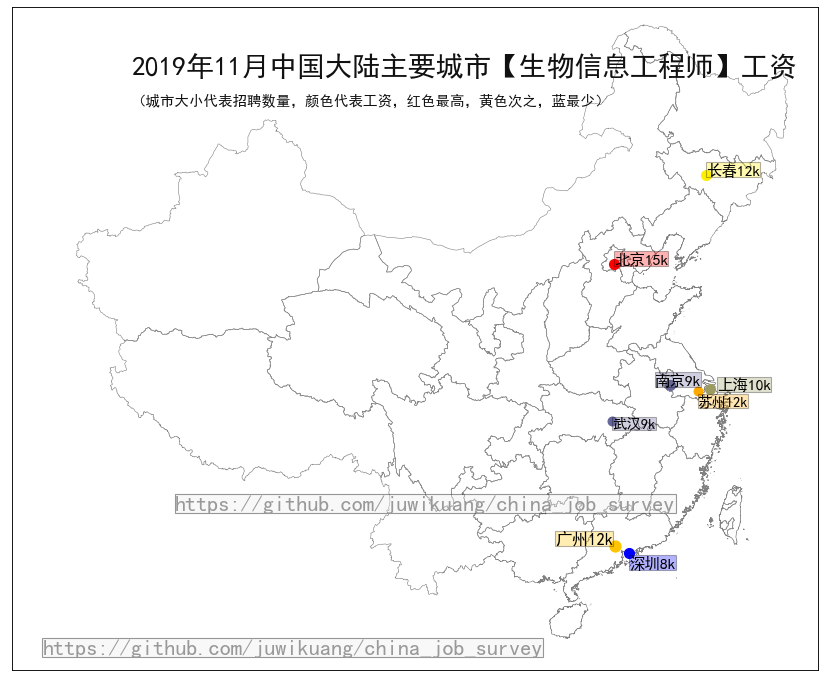

In [27]:
draw_map(data_bio,2,f'{year}年{month}月中国大陆主要城市【生物信息工程师】工资')

# 爬虫工程师

In [28]:
data_spider=get_sub_stats_by_col(data[data.career=='爬虫工程师'],'city')
data_spider=data_spider[data_spider['招聘人数']>10]
data_spider.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
5,北京,17393,1750,12500,35000,28,8.00%
11,南京,15538,11500,12500,20000,13,3.71%
1,广州,15274,7000,12357,37500,31,8.86%
4,上海,13532,4791,12500,28375,93,26.57%
2,深圳,12611,5250,10667,29983,54,15.43%
0,武汉,12136,7000,12000,20000,11,3.14%
10,杭州,11385,10500,11571,12500,13,3.71%
6,长沙,9474,7000,9200,12500,19,5.43%
16,合肥,7000,7000,7000,7000,17,4.86%
8,成都,6941,6000,6250,15750,34,9.71%


In [29]:
describe(data_spider, '爬虫工程师')

2019年11月北京招收爬虫工程师28人。2019年11月北京爬虫工程师平均工资17393元，工资中位数12500元，其中95%的人的工资介于1750元到35000元。

2019年11月南京招收爬虫工程师13人。2019年11月南京爬虫工程师平均工资15538元，工资中位数12500元，其中95%的人的工资介于11500元到20000元。

2019年11月广州招收爬虫工程师31人。2019年11月广州爬虫工程师平均工资15274元，工资中位数12357元，其中95%的人的工资介于7000元到37500元。

2019年11月上海招收爬虫工程师93人。2019年11月上海爬虫工程师平均工资13532元，工资中位数12500元，其中95%的人的工资介于4791元到28375元。

2019年11月深圳招收爬虫工程师54人。2019年11月深圳爬虫工程师平均工资12611元，工资中位数10667元，其中95%的人的工资介于5250元到29983元。

2019年11月武汉招收爬虫工程师11人。2019年11月武汉爬虫工程师平均工资12136元，工资中位数12000元，其中95%的人的工资介于7000元到20000元。

2019年11月杭州招收爬虫工程师13人。2019年11月杭州爬虫工程师平均工资11385元，工资中位数11571元，其中95%的人的工资介于10500元到12500元。

2019年11月长沙招收爬虫工程师19人。2019年11月长沙爬虫工程师平均工资9474元，工资中位数9200元，其中95%的人的工资介于7000元到12500元。

2019年11月合肥招收爬虫工程师17人。2019年11月合肥爬虫工程师平均工资7000元，工资中位数7000元，其中95%的人的工资介于7000元到7000元。

2019年11月成都招收爬虫工程师34人。2019年11月成都爬虫工程师平均工资6941元，工资中位数6250元，其中95%的人的工资介于6000元到15750元。

2019年11月西安招收爬虫工程师12人。2019年11月西安爬虫工程师平均工资6083元，工资中位数6250元，其中95%的人的工资介于5250元到6250元。



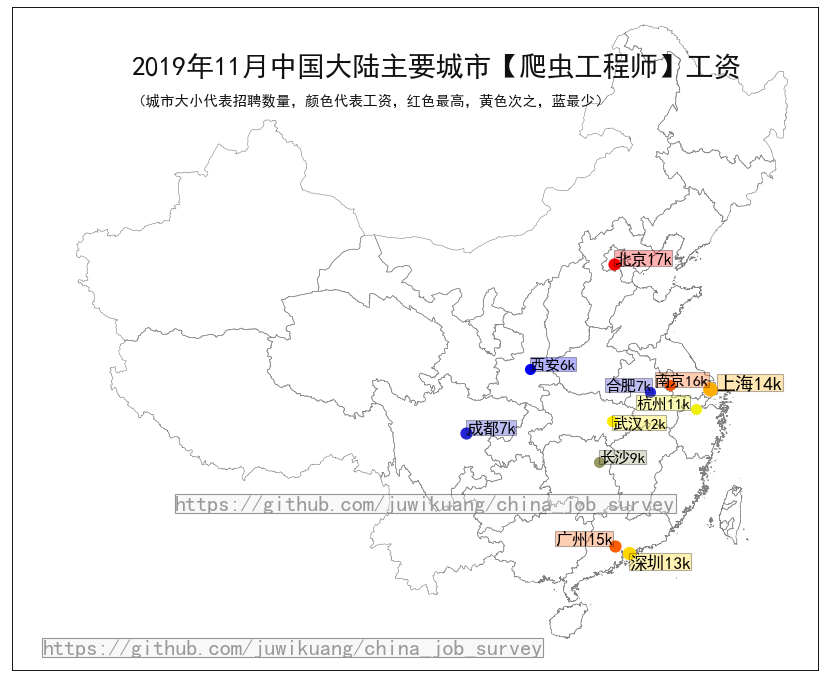

In [30]:
draw_map(data_spider,5,f'{year}年{month}月中国大陆主要城市【爬虫工程师】工资')

# Java程序员

In [31]:
data_java=get_sub_stats_by_col(data[(data.pl_java==1)],'city')
data_java.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
7,北京,16644,3750,14500,37500,11616,10.13%
6,上海,16543,5500,15000,35000,19133,16.68%
12,深圳,16256,6000,15000,37500,15351,13.38%
1,杭州,14983,3750,13000,32500,6374,5.56%
2,广州,13763,3750,12500,30000,13706,11.95%
5,南京,12816,4258,12500,26801,7449,6.49%
19,东莞,12613,3750,12500,24303,1052,0.92%
4,大连,12460,2500,11000,30000,5147,4.49%
3,成都,11683,3300,11000,25000,4772,4.16%
17,苏州,11632,3750,10500,25000,2427,2.12%


In [32]:
describe(data_java, 'Java程序员')

2019年11月北京招收Java程序员11616人。2019年11月北京Java程序员平均工资16644元，工资中位数14500元，其中95%的人的工资介于3750元到37500元。

2019年11月上海招收Java程序员19133人。2019年11月上海Java程序员平均工资16543元，工资中位数15000元，其中95%的人的工资介于5500元到35000元。

2019年11月深圳招收Java程序员15351人。2019年11月深圳Java程序员平均工资16256元，工资中位数15000元，其中95%的人的工资介于6000元到37500元。

2019年11月杭州招收Java程序员6374人。2019年11月杭州Java程序员平均工资14983元，工资中位数13000元，其中95%的人的工资介于3750元到32500元。

2019年11月广州招收Java程序员13706人。2019年11月广州Java程序员平均工资13763元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年11月南京招收Java程序员7449人。2019年11月南京Java程序员平均工资12816元，工资中位数12500元，其中95%的人的工资介于4258元到26801元。

2019年11月东莞招收Java程序员1052人。2019年11月东莞Java程序员平均工资12613元，工资中位数12500元，其中95%的人的工资介于3750元到24303元。

2019年11月大连招收Java程序员5147人。2019年11月大连Java程序员平均工资12460元，工资中位数11000元，其中95%的人的工资介于2500元到30000元。

2019年11月成都招收Java程序员4772人。2019年11月成都Java程序员平均工资11683元，工资中位数11000元，其中95%的人的工资介于3300元到25000元。

2019年11月苏州招收Java程序员2427人。2019年11月苏州Java程序员平均工资11632元，工资中位数10500元，其中95%的人的工资介于3750元到25000元。

2019年11月武汉招收Java程序员5663人。2019年11月武汉Java程序员平均工资11458元，工资中位数10500元，其中95%的人的工资介

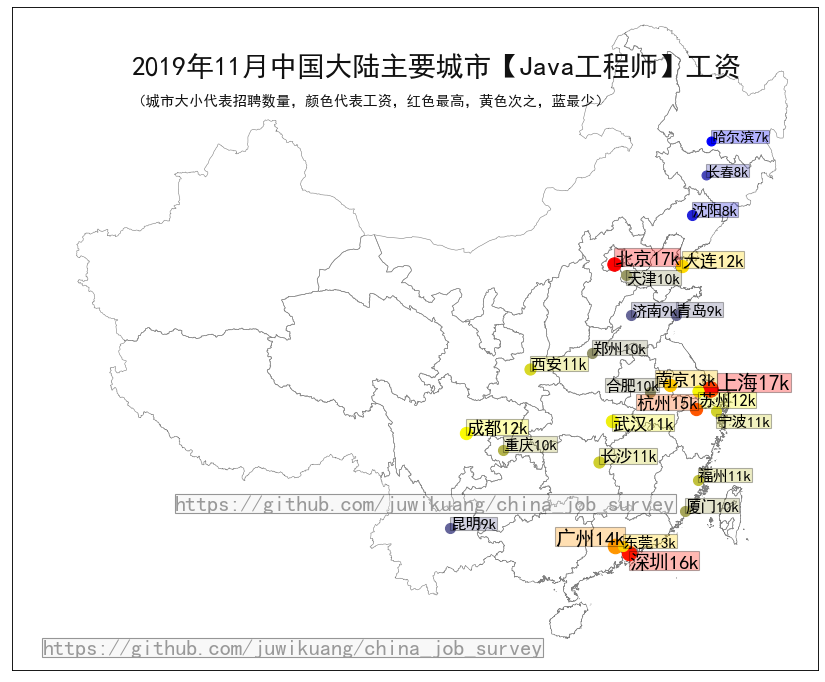

In [33]:
draw_map(data_java, 500, f'{year}年{month}月中国大陆主要城市【Java工程师】工资')

# Python程序员

In [34]:
data_python=get_sub_stats_by_col(data[(data.pl_python==1)],'city')

data_python.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
0,北京,23253,3941,21500,58333,4141,14.75%
2,上海,20785,6500,19000,45000,5948,21.19%
5,深圳,19818,6500,17500,45000,3975,14.16%
4,杭州,16886,3867,15000,45000,1615,5.75%
1,广州,16741,4000,15000,37500,2840,10.12%
9,苏州,15452,5250,12500,45500,696,2.48%
8,成都,15237,3750,14000,33982,1478,5.27%
7,南京,14597,4362,14000,30000,1752,6.24%
10,武汉,14272,5065,12500,29774,1358,4.84%
6,重庆,13617,4124,12500,32675,333,1.19%


In [35]:
describe(data_python, 'Python程序员')

2019年11月北京招收Python程序员4141人。2019年11月北京Python程序员平均工资23253元，工资中位数21500元，其中95%的人的工资介于3941元到58333元。

2019年11月上海招收Python程序员5948人。2019年11月上海Python程序员平均工资20785元，工资中位数19000元，其中95%的人的工资介于6500元到45000元。

2019年11月深圳招收Python程序员3975人。2019年11月深圳Python程序员平均工资19818元，工资中位数17500元，其中95%的人的工资介于6500元到45000元。

2019年11月杭州招收Python程序员1615人。2019年11月杭州Python程序员平均工资16886元，工资中位数15000元，其中95%的人的工资介于3867元到45000元。

2019年11月广州招收Python程序员2840人。2019年11月广州Python程序员平均工资16741元，工资中位数15000元，其中95%的人的工资介于4000元到37500元。

2019年11月苏州招收Python程序员696人。2019年11月苏州Python程序员平均工资15452元，工资中位数12500元，其中95%的人的工资介于5250元到45500元。

2019年11月成都招收Python程序员1478人。2019年11月成都Python程序员平均工资15237元，工资中位数14000元，其中95%的人的工资介于3750元到33982元。

2019年11月南京招收Python程序员1752人。2019年11月南京Python程序员平均工资14597元，工资中位数14000元，其中95%的人的工资介于4362元到30000元。

2019年11月武汉招收Python程序员1358人。2019年11月武汉Python程序员平均工资14272元，工资中位数12500元，其中95%的人的工资介于5065元到29774元。

2019年11月重庆招收Python程序员333人。2019年11月重庆Python程序员平均工资13617元，工资中位数12500元，其中95%的人的工资介于4124元到32675元。

2019年11月长沙招收Python程序员548人。2019年11月长沙Python

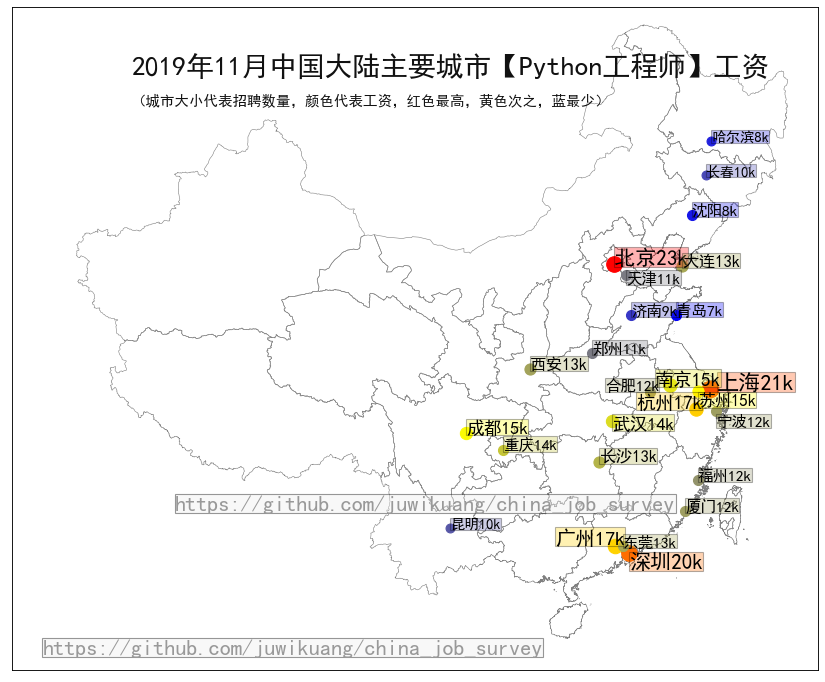

In [36]:
draw_map(data_python, 100,  f'{year}年{month}月中国大陆主要城市【Python工程师】工资')

In [37]:
history_data = pd.read_sql(sql='select * from CityStats', con=conn)

In [38]:
del history_data['Id']

In [39]:
history_data.head()

,Month,City,Salary
0,201906,哈尔滨,5983
1,201906,杭州,14707
2,201906,厦门,9789
3,201906,苏州,11197
4,201906,长沙,10852


In [40]:
data_hangzhou = history_data[history_data.City=='杭州']

In [41]:
del data_hangzhou['City']

In [42]:
import matplotlib.pyplot as plt

In [43]:
data_hangzhou.Salary.values

array([14707, 14980, 15106, 14980, 14758, 14921], dtype=int64)

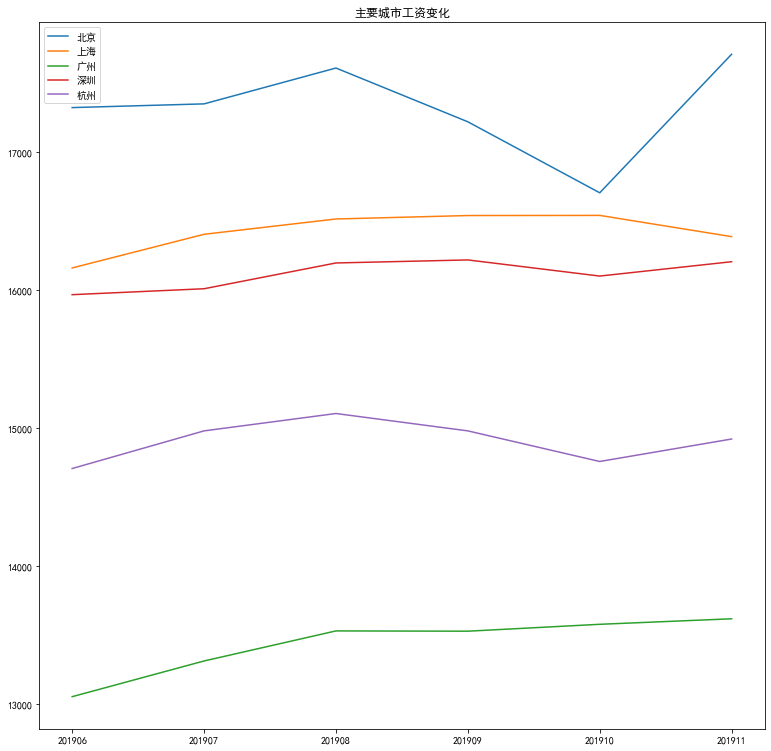

In [44]:
#plt.plot("Month","Salary",data=data_hangzhou, label='杭州')
#plt.plot("Month","Salary",data=history_data[history_data.City=='南京'], label='南京')
cities = set(history_data.City)
cities = ['北京','上海','广州','深圳','杭州']
for city in cities:
    plt.plot("Month","Salary",data=history_data[history_data.City==city], label=city)
    
    #plt.show()
plt.title('主要城市工资变化')
plt.legend()